<a href="https://colab.research.google.com/github/AmrMomtaz/Modulation-Classification/blob/main/Modulation_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modulation Classification

## Installation and Managing Data

In [1]:
# Importing all the project depenedencies and libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as it
import keras
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
import keras.models as models
from keras.layers.convolutional import Convolution2D, ZeroPadding2D
from keras.regularizers import *
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from tqdm import trange, tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from keras.layers import LSTM
from keras.layers import SimpleRNN

In [2]:
# Loading the dataset
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/Pattern Recognition/MC/RML2016.10b.dat'
file = open(DATASET_PATH,'rb')
Xd = pickle.load(file, encoding = 'bytes')
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
mods = [str(x).split('\'')[1] for x in mods]
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [3]:
# Splitting the dataset to 70% train and validation and 30% testing
np.random.seed(17)
n_examples = X.shape[0]

indeces = list(range(0,n_examples))
train_idx = np.random.choice(indeces, size= int(n_examples * 0.7), replace=False)
indeces = list(set(indeces) - set(train_idx))
validation_idx = np.random.choice(indeces, size=int(n_examples * 0.035), replace=False)
train_idx = list(set(train_idx) - set(validation_idx))
test_idx = list(indeces)

X_train = X[train_idx]
X_validation = X[validation_idx]
X_test =  X[test_idx]
def to_onehot(yy):
  yy = list(yy)
  yy1 = np.zeros([len(yy), 10])
  yy1[np.arange(len(yy)),yy] = 1
  return yy1
Y_train = to_onehot(map(lambda x: mods.index(lbl[x][0]), train_idx))
Y_validation = to_onehot(map(lambda x: mods.index(lbl[x][0]), validation_idx))
Y_test = to_onehot(map(lambda x: mods.index(lbl[x][0]), test_idx))

## Building and Training model

In [4]:
# Building the model
in_shp = list(X_train.shape[1:])
classes = mods
dr = 0.5 # dropout rate (%)

model = models.Sequential()
model.add(Reshape([1]+in_shp, input_shape=in_shp))                                                  
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(64, (1, 3),  activation="relu", name="conv1",data_format='channels_first'))
model.add(Dropout(dr))                                                                             
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(16, (2, 3),  activation="relu", name="conv2",data_format='channels_first'))
model.add(Dropout(dr))
model.add(Flatten())                                                                                #transition from conv to dense, must flatten
model.add(Dense(128, activation='relu', name="dense1"))                                             #output = activation(dot(input, kernel) + bias)
model.add(Dropout(dr))
model.add(Reshape((4,-1)))
model.add(LSTM(len(classes)))   # Uses LSTM
#model.add(SimpleRNN(len(classes))) # Uses Vanilla RNN
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1, 2, 128)         0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 1, 6, 128)        0         
 2D)                                                             
                                                                 
 conv1 (Conv2D)              (None, 64, 6, 126)        256       
                                                                 
 dropout (Dropout)           (None, 64, 6, 126)        0         
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 64, 10, 126)      0         
 ng2D)                                                           
                                                                 
 conv2 (Conv2D)              (None, 16, 9, 124)        6

In [6]:
# Setting up parameters
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
nb_epoch = 100    # number of epochs to train on
batch_size = 1024  # training batch size

In [7]:
# Training model
filepath = '/content/drive/MyDrive/Colab Notebooks/Pattern Recognition/MC/convmodrecnets_CNN2_0.5.wts.h5'
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_validation, Y_validation),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])

Epoch 1/100
821/821 - 93s - loss: 1.8174 - val_loss: 1.7476 - 93s/epoch - 113ms/step
Epoch 2/100
821/821 - 77s - loss: 1.7949 - val_loss: 1.7380 - 77s/epoch - 94ms/step
Epoch 3/100
821/821 - 77s - loss: 1.7817 - val_loss: 1.7216 - 77s/epoch - 93ms/step
Epoch 4/100
821/821 - 76s - loss: 1.7699 - val_loss: 1.7100 - 76s/epoch - 93ms/step
Epoch 5/100
821/821 - 76s - loss: 1.7523 - val_loss: 1.6827 - 76s/epoch - 92ms/step
Epoch 6/100
821/821 - 76s - loss: 1.7139 - val_loss: 1.6292 - 76s/epoch - 92ms/step
Epoch 7/100
821/821 - 75s - loss: 1.6768 - val_loss: 1.6011 - 75s/epoch - 92ms/step
Epoch 8/100
821/821 - 75s - loss: 1.6589 - val_loss: 1.6009 - 75s/epoch - 92ms/step
Epoch 9/100
821/821 - 75s - loss: 1.6478 - val_loss: 1.5815 - 75s/epoch - 92ms/step
Epoch 10/100
821/821 - 75s - loss: 1.6364 - val_loss: 1.5774 - 75s/epoch - 92ms/step
Epoch 11/100
821/821 - 74s - loss: 1.6316 - val_loss: 1.5823 - 74s/epoch - 91ms/step
Epoch 12/100
821/821 - 75s - loss: 1.6273 - val_loss: 1.5643 - 75s/epoch 

## Testing the model

In [8]:
# Loading model best weigths
filepath = '/content/drive/MyDrive/Colab Notebooks/Pattern Recognition/MC/convmodrecnets_CNN2_0.5.wts.h5'
model.load_weights(filepath)

In [9]:
# Evaluating model
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
score

1.5554718971252441

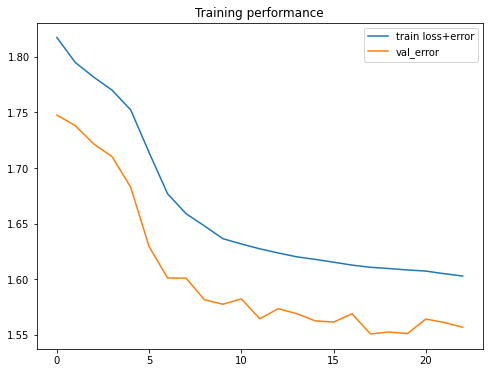

In [10]:
#@title
# Plotting the losses
plt.figure(figsize = (8,6))
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend();

In [18]:
# Confusion matrix plotting function
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.figure(figsize = (8,6));
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label');

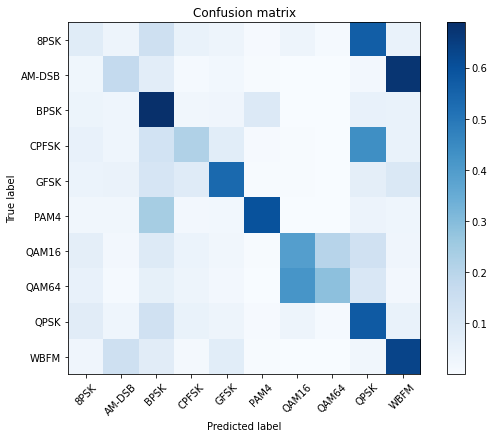

In [19]:
#@title
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes);

In [21]:
# Printing the classification report
from sklearn.metrics import classification_report
y_true = np.argmax(Y_test,axis=1)
y_pred = np.argmax(test_Y_hat,axis=1)
print(classification_report(y_true, y_pred, target_names=mods))

              precision    recall  f1-score   support

        8PSK       0.17      0.08      0.11     36274
      AM-DSB       0.32      0.18      0.23     35878
        BPSK       0.39      0.69      0.50     36071
       CPFSK       0.41      0.22      0.29     35754
        GFSK       0.62      0.54      0.57     35760
        PAM4       0.82      0.60      0.69     36156
       QAM16       0.44      0.39      0.41     36052
       QAM64       0.56      0.29      0.38     36095
        QPSK       0.28      0.58      0.38     35919
        WBFM       0.38      0.63      0.47     36041

    accuracy                           0.42    360000
   macro avg       0.44      0.42      0.40    360000
weighted avg       0.44      0.42      0.40    360000



Overall Accuracy (snr:-20): 0.10469273109005277
Overall Accuracy (snr:-18): 0.10713296015075098
Overall Accuracy (snr:-16): 0.11929552503322995
Overall Accuracy (snr:-14): 0.13275795723159806
Overall Accuracy (snr:-12): 0.15731325234980487
Overall Accuracy (snr:-10): 0.20228141093083782
Overall Accuracy (snr:-8): 0.2825230699977493
Overall Accuracy (snr:-6): 0.41543189551092086
Overall Accuracy (snr:-4): 0.5057983942908117
Overall Accuracy (snr:-2): 0.5280017796563039
Overall Accuracy (snr:0): 0.5480175721514764
Overall Accuracy (snr:2): 0.5581886960391633
Overall Accuracy (snr:4): 0.5750124055797541
Overall Accuracy (snr:6): 0.582886805090422
Overall Accuracy (snr:8): 0.5907520891364902
Overall Accuracy (snr:10): 0.5818963111780792
Overall Accuracy (snr:12): 0.5938876651982379
Overall Accuracy (snr:14): 0.597619312493047
Overall Accuracy (snr:16): 0.5922064890177278
Overall Accuracy (snr:18): 0.5954806033283242


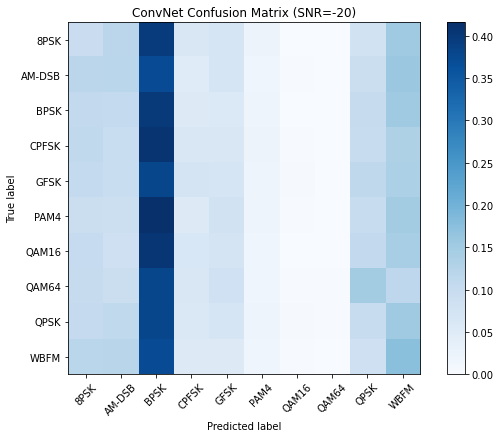

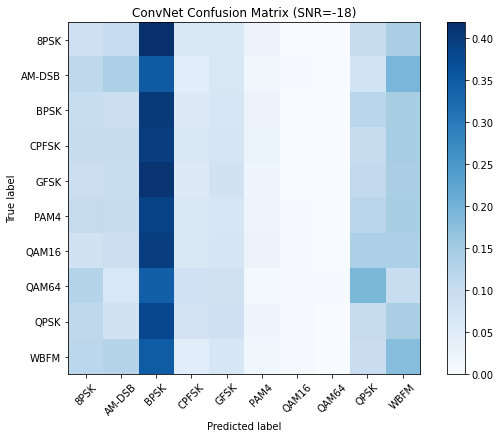

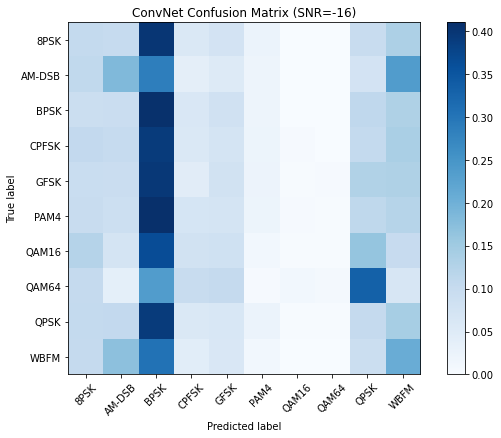

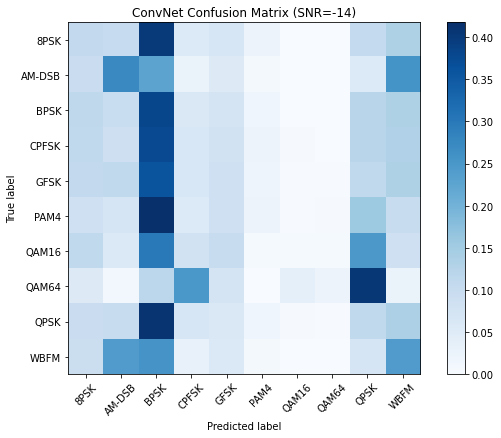

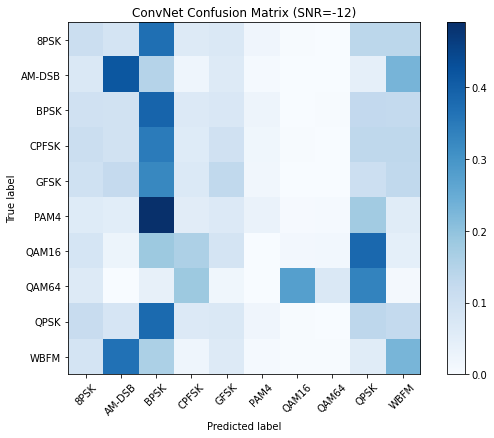

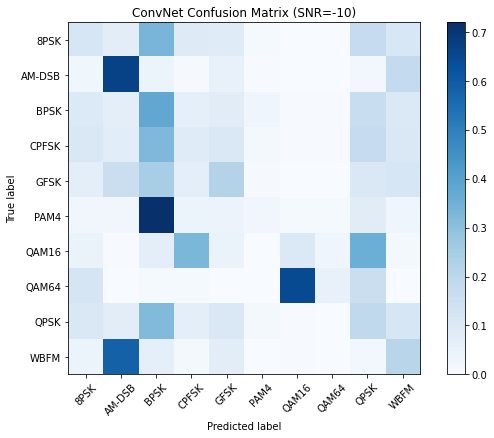

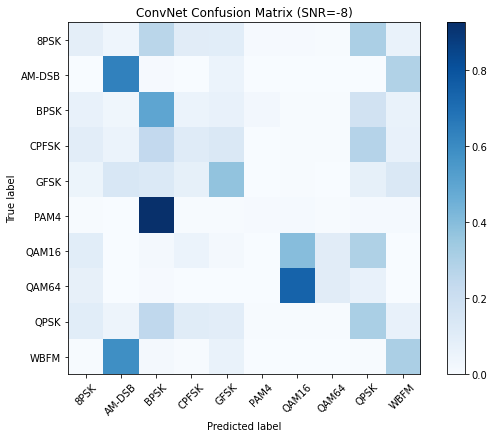

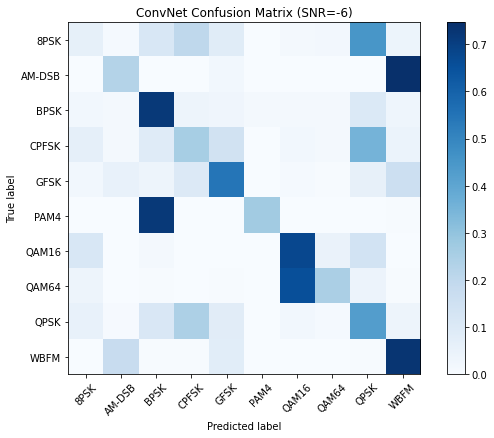

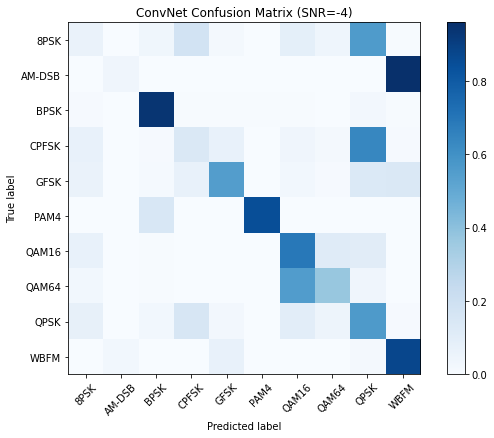

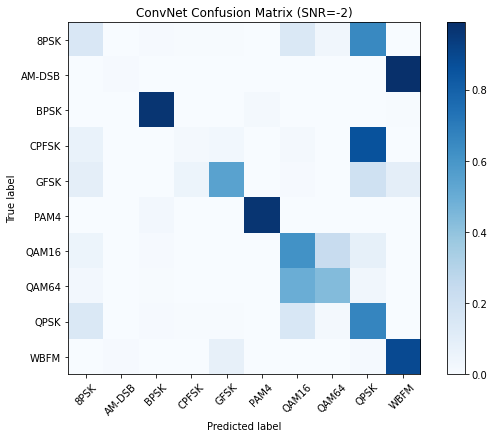

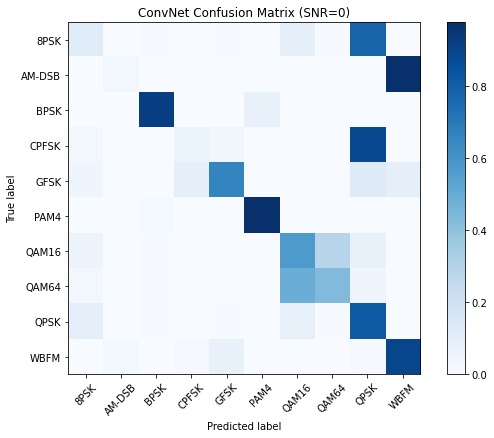

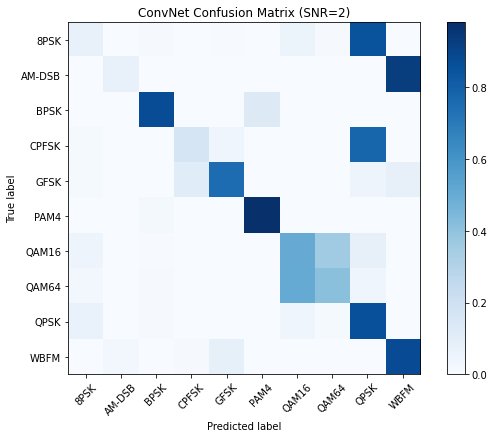

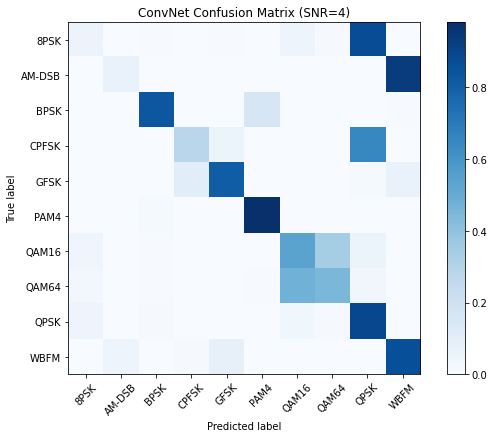

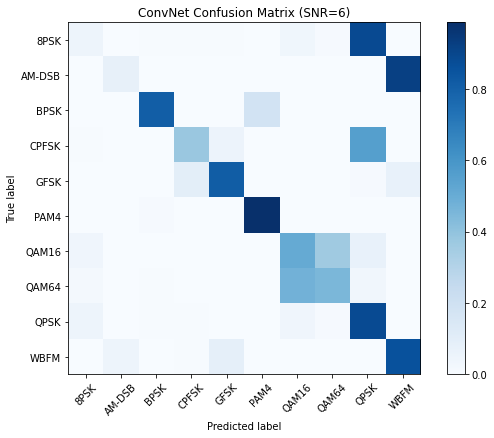

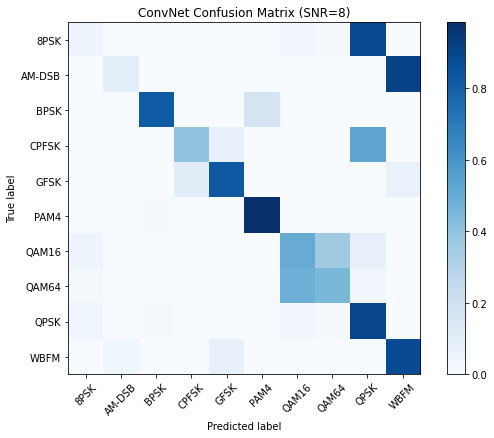

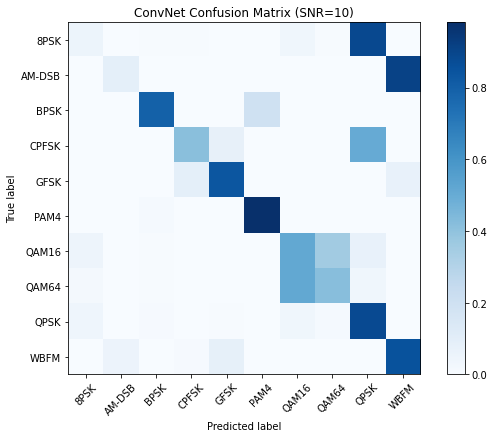

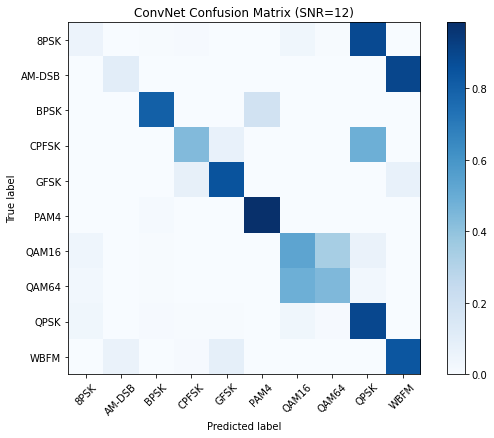

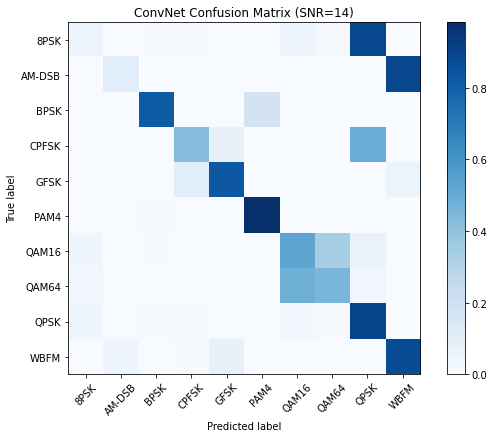

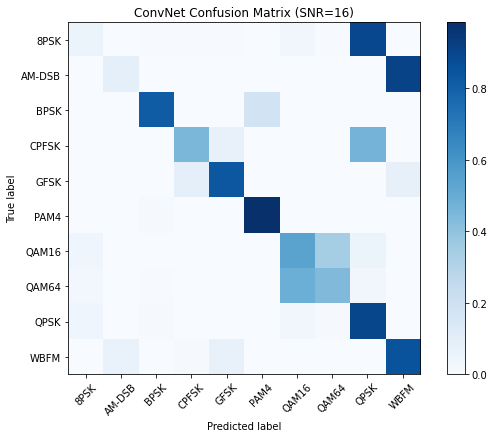

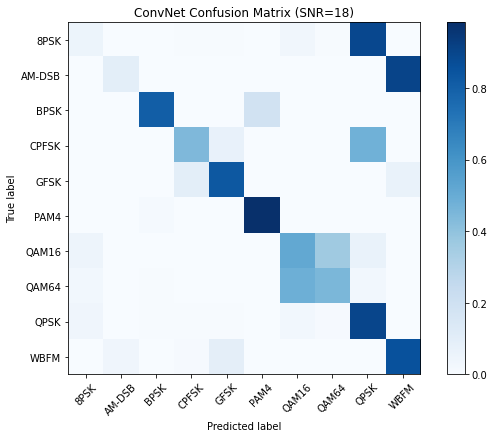

In [22]:
#@title
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print(f'Overall Accuracy (snr:{snr}): {cor / (cor+ncor)}')
    acc[snr] = 1.0*cor/(cor+ncor)

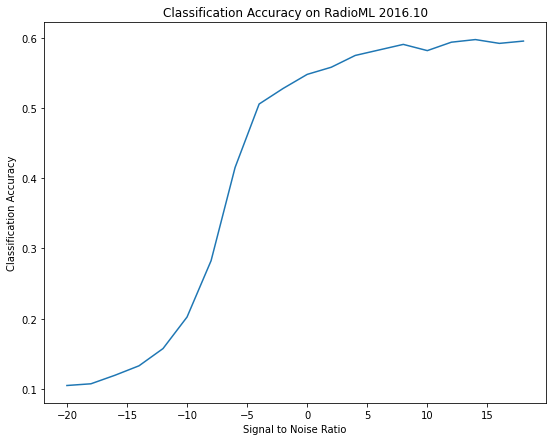

In [23]:
#@title
# Plot accuracy curve against SNR
plt.figure(figsize = (9,7));
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("Classification Accuracy on RadioML 2016.10");

## References

* https://www.deepsig.ai/datasets
* https://github.com/radioML/examples/blob/master/modulation_recognition/RML2016.10a_VTCNN2_example.ipynb